In [ ]:
# Setting html stuff for the rest of the notebook
from IPython.core.display import display, HTML, Javascript
html_contents ="""

<!DOCTYPE html>
<html lang="en">
    <head>
    <style>
    
    .top_section{
        background-color: #a13d2d;
        color: black;
        font-family: Copperplate, Papyrus, fantasy;
        font-weight: 800;
        font-size: 25px;
        padding: 8px 14px;
        margin-bottom: 6px;
    }
    
    .section_title{
        background-color: #FF8C00;
        color: black;
        font-family: Copperplate, Papyrus, fantasy;
        font-weight: 600;
        font-size: 25px;
        padding: 6px 12px;
        margin-bottom: 5px;
    }
    .subsection_title{
        background: #FFD580;
        font-weight: 400;
        color: black;
        font-family: Copperplate, Papyrus, fantasy;
        font-size: 21px;
        padding: 6px 12px;
        margin-bottom: 0px;
    }
    .subsection_detail{
        background: #D3D3D3;
        font-weight: 300;
        color: black;
        font-family: Copperplate, Papyrus, fantasy;
        font-size: 18px;
        border: 1px solid #d7d7d7;
        padding: 1px 10px 2px;
        box-shadow: 1px 1px 2px 1px rgba(0,0,0,0.3);
        margin-bottom: 3px;
    }
    </style>
    </head>
    
</html>
"""

HTML(html_contents)

# <div class="top_section">1. Introduction</div>


Hello fellow kagglers! In this notebook we're going to analyse the  <span style="color:red;"> Cdiscount’s Image Classification Challenge </span> by doing so we're going to get some insights. I will be releasing series of notebook 
we will go step by step procedure as below,

1. Preprocessing.

2. Getting Structured data.

3. Training Basic Model and debugging.

4. Tuning Basic Model. Improving the basic model by adding layers or going for some better architecture based on technical papers.

5. getting the best final model.

6. Error analysis of the best model.

7. Writing Final function to the model.

8. Submitting the final model predictions.

- In this notebook will explore the dataset and get some insights:


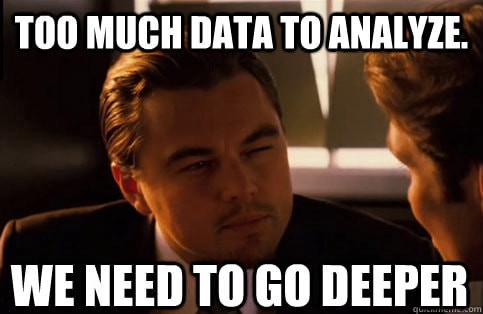!



- Let's get started...

# <div class="section_title">1.1 AIM:</div>
- The aim of this challenge is to develop a product classifier based on image analysis.




# <div class="section_title">1.2 The Business Problem:</div>
Cdiscount e-commerce company currently applies machine learning algorithms to the text description of the products in order to automatically predict their category. As these methods now seem close to their maximum potential, Cdiscount.com believes that the next quantitative improvement will be driven by the application of data science techniques to images to attract more users to their website by using image classification algorithms to their search engine and product recommendation.


 # <div class="section_title">2 The Data::</div>

Dataset announced features:

- Almost 9 million products: half of the current catalogue
- More than 15 million images at 180x180 resolution
- More than 5000 categories: yes this is quite an extreme multi-class classification!

Let's explore this in details
    


In [ ]:
path = '../input/cdiscount-image-classification-challenge'
!ls "$path"

In [ ]:
# Lets read the file 

import os
import io
import sys
import numpy as np 
import pandas as pd 
import bson
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread
from PIL import Image
import seaborn as sns


category_name_df = pd.read_csv('../input/cdiscount-image-classification-challenge/category_names.csv')
test_bson_file =  bson.decode_file_iter(open('../input/cdiscount-image-classification-challenge/test.bson', 'rb'))
train_bson_file = bson.decode_file_iter(open('../input/cdiscount-image-classification-challenge/train.bson', 'rb'))
train_example_bson_file = bson.decode_file_iter(open('../input/cdiscount-image-classification-challenge/train_example.bson', 'rb'))
sample_submission_file = pd.read_csv('../input/cdiscount-image-classification-challenge/sample_submission.csv')

In [ ]:
# To view the sample data format

for c, d in enumerate(train_example_bson_file):
    if c == 1:
        break
    print("Sample data format :",c)
    print()
    print(d)


- Data is stored in dictionary  having keys as `_id`, `category_id` and `imgs` as the keys

        {'_id' : unique int

         'category_id' : 1000010653 # sample category ID

         'imgs' : [{'picture' : b" "},{picture' : b" "},{'picture' : b" "},{'picture' : b" "} ] # images may vary from 1-4 

         } 
 
- same for test data except no **`category_id`** key 

In [ ]:
prod_to_category = dict()

for c, d in enumerate(train_example_bson_file):
    product_id = d['_id']
    category_id = d['category_id']
    prod_to_category[product_id] = category_id
    
prod_to_category = pd.DataFrame.from_dict(prod_to_category, orient='index')
prod_to_category.index.name = '_id'
prod_to_category.rename(columns={0: 'category_id'}, inplace=True)
prod_to_category

Table category_name_csv shows the hierarchy of product classification.

> category_id has 3 category tags of different levels

Using category_id field we can associate image to 3 levels of category tags, label


In [ ]:
level_tags = category_name_df.columns[1:]
category_name_df.head()

# <div class="subsection_title">Lets visualize some train images with its label and category ID</div>

In [ ]:
# Method to compose a single image from 1 - 4 images

def decode_images(item_imgs):
    nx = 2 if len(item_imgs) > 1 else 1
    ny = 2 if len(item_imgs) > 2 else 1
    composed_img = np.zeros((ny * 180, nx * 180, 3), dtype=np.uint8)
    for i, img_dict in enumerate(item_imgs):
        img = decode(img_dict['picture'])
        h, w, _ = img.shape        
        xstart = (i % nx) * 180
        xend = xstart + w
        ystart = (i // nx) * 180
        yend = ystart + h
        composed_img[ystart:yend, xstart:xend] = img
    return composed_img


def decode(data):
    arr = np.asarray(bytearray(data), dtype=np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 


def decode_pil(data):
    return Image.open(io.BytesIO(data))

In [ ]:
max_counter = 16
counter = 0
n = 4

for item in bson.decode_file_iter(open('../input/cdiscount-image-classification-challenge/train.bson', 'rb')):  
    if counter % n == 0:
        plt.figure(figsize=(14, 12))
    
    mask = category_name_df['category_id'] == item['category_id']    
    plt.subplot(1, n, counter % n + 1)
    cat_levels = category_name_df[mask][level_tags].values.tolist()[0]
    cat_levels = [c[:25] for c in cat_levels]
    title = str(item['category_id']) + '\n\n'
    title += '\n'.join(cat_levels)
    plt.title(title+'\n')
    plt.imshow(decode_images(item['imgs']))
    plt.axis('off')
    
    counter += 1
    if counter == max_counter:
        break

# <div class="subsection_title">Lets visualize some test images with only `_id` and no  label/category ID</div>

In [ ]:
max_counter = 16
counter = 0
n = 4

for item in bson.decode_file_iter(open('../input/cdiscount-image-classification-challenge/test.bson', 'rb')):  
    if counter % n == 0:
        plt.figure(figsize=(14, 12))
    plt.subplot(1, n, counter % n + 1)

    plt.title(item['_id'])
    plt.imshow(decode_images(item['imgs']))
    plt.axis('off')
    
    counter += 1
    if counter == max_counter:
        break

# <div class="section_title">2.1 Analyzing categories Feature</div>


In [ ]:
print("Unique categories: ", len(category_name_df['category_id'].unique()))
print("Unique level 1 categories: ", len(category_name_df['category_level1'].unique()))
print("Unique level 2 categories: ", len(category_name_df['category_level2'].unique()))
print("Unique level 3 categories: ", len(category_name_df['category_level3'].unique()))

Let's inspect categories and their relationship to images. We have
* 5270 unique categories
* 49 unique level 1 categories
* 483 unique level 2 categories
* 5263 unique level 3 categories


In [ ]:
# let print some unique category found in level 1
for i in category_name_df['category_level1'].unique():
    print(i)

In [ ]:
plt.figure(figsize=(12,12))
_ = sns.countplot(y=category_name_df['category_level1'])

In [ ]:
# Most frequent category level 1 to low freuqent category

cat_level2_counts = category_name_df.groupby('category_level1')['category_level1'].count()
cat_level2_counts.sort_values(ascending = False)

In [ ]:
from tqdm.notebook import tqdm

num_dicts = 7069896 # according to data page
prod_to_category = [None] * num_dicts

with tqdm(total=num_dicts) as bar:        
    train_data = bson.decode_file_iter(open('../input/cdiscount-image-classification-challenge/train.bson', 'rb'))

    for i, item in enumerate(train_data):
        bar.update()
        prod_to_category[i] = (item['_id'], item['category_id'])

In [ ]:
train_category_df = pd.DataFrame(prod_to_category, columns=['_id', 'category_id'])
train_category_df.head()

In [ ]:
print("Total number of product available in train data set:",len(train_category_df))
print("Total number of unique category found:", len(train_category_df['category_id'].unique()))

In [ ]:
# Top 10 most frequent  catergory_ID

top_10_most_used_frequent_id = train_category_df.groupby('category_id')['category_id'].count().sort_values(ascending=False)[:10]
top_10_less_used_frequent_id = train_category_df.groupby('category_id')['category_id'].count().sort_values(ascending=True)[:10]

top_10_most_used_frequent_id

In [ ]:
for cat_id in top_10_most_used_frequent_id.index:
    print(f"{category_name_df[category_name_df['category_id'] == cat_id].category_level1.values[0]} - {category_name_df[category_name_df['category_id'] == cat_id].category_level2.values[0]} = {category_name_df[category_name_df['category_id'] == cat_id].category_level3.values[0]}")

In [ ]:
for cat_id in top_10_less_used_frequent_id.index:
    print(f"{category_name_df[category_name_df['category_id'] == cat_id].category_level1.values[0]} - {category_name_df[category_name_df['category_id'] == cat_id].category_level2.values[0]} = {category_name_df[category_name_df['category_id'] == cat_id].category_level3.values[0]}")

# Observations:
* Data set is very large having almost 9 million products
* More than 15 million images at 180x180 resolution
* More than 5000 categories.
* This is quite an extreme multi-class classification!
